# 버트를 활용한 한국어 텍스트 유사도 모델

In [1]:
import os
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

In [2]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir= 'bert_ckpt', do_lower_case=False)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
# random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

# BASE PARAM

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 28 * 2

DATA_IN_PATH = './data_in/KOR'
DATA_OUT_PATH = './data_out/KOR'

In [6]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

print('-' * 20)
# Test Tokenizers
kor_encode = tokenizer.encode('안녕하세요, 반갑습니다')
eng_encode = tokenizer.encode("Hello world")

kor_decoder = tokenizer.decode(kor_encode)
eng_decoder = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print('-' * 20)
print(kor_decoder)
print(eng_decoder)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
--------------------
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[101, 31178, 11356, 102]
--------------------
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] Hello world [SEP]


# KorSTS Dataset

Data from Kakaobrain:  https://github.com/kakaobrain/KorNLUDatasets

In [7]:
# Load Train dataset

TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')
DEV_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-dev.tsv')

train_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter = '\t', quoting = 3)
dev_data = pd.read_csv(DEV_STS_DF, header = 0, delimiter = '\t', quoting =3)

print("Total # dataset: train - {}, dev - {}".format(len(train_data), len(dev_data)))

Total # dataset: train - 5749, dev - 1500


In [15]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

def bert_tokenizer_v2(sent1, sent2, MAX_LEN):
    
    # For Two sentence input
    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [23]:
from transformers import logging

# 로깅 레벨을 Error로 설정
logging.set_verbosity_error()

In [24]:
def clean_text(sent):
    sent_clean = re.sub("[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]", " ", sent)
    return sent_clean

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_labels = np.array(data_labels)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
print(train_input_ids.shape)
print(train_attention_masks.shape)
print(train_type_ids.shape)

(5749, 56)
(5749, 56)
(5749, 56)


# DEV SET Preprocessing

In [26]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [27]:
print(f"# train labels: {len(train_data_labels)}, #dev labels: {len(dev_data_labels)}")

# train labels: 5749, #dev labels: 1500


In [28]:
class TFBertRegressor(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertRegressor, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir= dir_path)
        self.num_class = num_class
        # BERT 모델이 사전 학습에 사용한 드롭아웃 비율을 그대로 유지
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.regressor = tf.keras.layers.Dense(self.num_class, 
                                               kernel_initializer = tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                               name="regressor")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        # output 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids = token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training = training)
        logits = self.regressor(pooled_output)

        return logits

In [29]:
regression_model = TFBertRegressor(model_name= 'bert-base-multilingual-cased',
                                   dir_path = 'bert_ckpt',
                                   num_class=1)

In [32]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name = "pearson_correlation", ** kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)

        return  pearson_correlation

    def reset_state(self):
        self.y_true_list = []
        self.y_pred_list = []

    # 실제값과 예측값 사이의 상관계수를 구하는 함수 (두 변수의 선형 관계를 파악하는데 유용함)
    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true - m_true, pred - m_pred  # 오타 수정
        num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return num / den

        

In [33]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, loss= loss, metrics=[metric], run_eagerly=True)

In [35]:
#학습 진행하기
model_name = "tf2_BERT_KorSTS"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=2,mode='max')
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, '.weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

# 학습과 eval 시작
history = regression_model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

./data_out/KOR/tf2_BERT_KorSTS -- Folder already exists 

Epoch 1/3
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 6.1794 - pearson_correlation: 0.0445
Epoch 1: val_pearson_correlation improved from -inf to 0.20735, saving model to ./data_out/KOR/tf2_BERT_KorSTS/.weights.h5
180/180 ━━━━━━━━━━━━━━━━━━━━ 1228s 7s/step - loss: 6.1743 - pearson_correlation: 0.0445 - val_loss: 3.1787 - val_pearson_correlation: 0.2074
Epoch 2/3
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 3.5938 - pearson_correlation: 0.0406
Epoch 2: val_pearson_correlation did not improve from 0.20735
180/180 ━━━━━━━━━━━━━━━━━━━━ 1384s 8s/step - loss: 3.5920 - pearson_correlation: 0.0406 - val_loss: 2.4347 - val_pearson_correlation: 0.1967
Epoch 3/3
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 2.8099 - pearson_correlation: 0.0458
Epoch 3: val_pearson_correlation did not improve from 0.20735
180/180 ━━━━━━━━━━━━━━━━━━━━ 1455s 8s/step - loss: 2.8094 - pearson_correlation: 0.0459 - val_loss: 2.3180 - val_pearson_correla

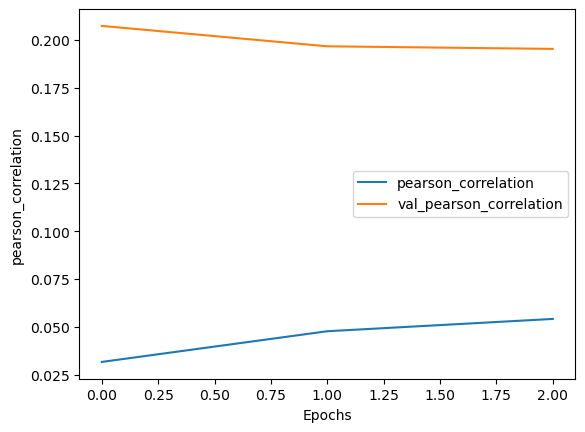

In [36]:
plot_graphs(history, 'pearson_correlation')

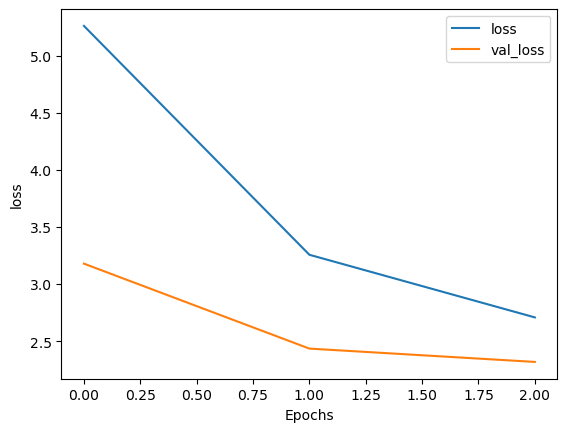

In [37]:
plot_graphs(history, 'loss')

# KorSTS Test dataset

In [38]:
# Load TEST dataset

TEST_STS_DF = os.path.join(DATA_IN_PATH, 'KorSTS', 'sts-train.tsv')

test_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter = '\t', quoting = 3)
test_data.head(10)

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.
5,main-captions,MSRvid,2012test,11,4.25,몇몇 남자들이 싸우고 있다.,두 남자가 싸우고 있다.
6,main-captions,MSRvid,2012test,12,0.50,남자가 담배를 피우고 있다.,남자가 스케이트를 타고 있다.
7,main-captions,MSRvid,2012test,13,1.60,남자가 피아노를 치고 있다.,남자가 기타를 연주하고 있다.
8,main-captions,MSRvid,2012test,14,2.20,한 남자가 기타를 치고 노래를 부르고 있다.,한 여성이 어쿠스틱 기타를 연주하고 노래를 부르고 있다.
9,main-captions,MSRvid,2012test,16,5.00,사람이 고양이를 천장에 던지고 있다.,사람이 고양이를 천장에 던진다.


In [39]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass
    
test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.array(data_labels)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [40]:
print("# sents: {}, # labels: {}".format(len(test_input_ids), len(test_data_labels)))

# sents: 1500, # labels: 1500


In [43]:
regression_model.load_weights(checkpoint_path)

results = regression_model.evaluate(test_inputs, test_data_labels, batch_size = 512)
print(f"test loss, test pearson correlation: {results}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 26s/step - loss: 3.1884 - pearson_correlation: 0.1565
test loss, test pearson correlation: [3.1786692142486572, 0.20735393464565277]
